This notebook is for experimenting with : <br>
&emsp;&emsp; 1. Method of extracting the data from TSPLIB dataset into a usable format<br>
&emsp;&emsp; 2. Simulated annealing for TSP with QUBO formulation.

## Reading TSPLIB data

#### Convert the tsp file into list

In [1]:
file1 = open('bays29.tsp')     #Test Dataset from Symmetric TSP
lines_list = file1.read().splitlines()

In [2]:
distance_list = lines_list[8:37]    #29 lines for distance values of each 29x29 node pairs
nodes_list = lines_list[38:-1]      #29 lines for the nodes coordinate values
# print(distance_list)
# print(nodes_list)

#### Convert the Lists into 2D Matrix

In [3]:
# The list containg the lines are split and null values are removed
distance_matrix = [0 for i in range (29)]
nodes_matrix = [0 for i in range(29)]
for i in range(29):
    d_row = distance_list[i].split(' ')
    d_row = list(filter(None,d_row))
    n_row = nodes_list[i].split(' ')
    n_row = list(filter(None,n_row))
    distance_matrix[i] = d_row
    nodes_matrix[i] = n_row
# print(distance_matrix)
# print(nodes_matrix)
    

In [4]:
# reshaping the matrices
import numpy as np
#Convert the lists to numpy arrays
distance_matrix = np.array(distance_matrix)
nodes_matrix = np.array(nodes_matrix)
distance_matrix = distance_matrix.reshape(29,29)        # Re-shape into 2D array
nodes_matrix = nodes_matrix.reshape(29,3)               # Re-shape into 2D array
distance_matrix = distance_matrix.astype(float)         # The elements of array were of string type
nodes_matrix = nodes_matrix.astype(float)               # So we convert them to float
nodes_matrix = nodes_matrix.astype(int)

In [5]:
# check the matrices
# print(distance_matrix)
# print(nodes_matrix)

## QUBO formulation using PyQUBO
### Docs: https://pyqubo.readthedocs.io/en/latest/index.html
<img src="https://raw.githubusercontent.com/recruit-communications/pyqubo/master/images/benchmark.svg" /> 

#### PyQUBO has been benchmarked on TSP problems and has a significant execution time advantage and is highly optimised.

#### Reference for code : https://github.com/recruit-communications/pyqubo/blob/master/notebooks/TSP.ipynb

In [6]:
%matplotlib inline
from pyqubo import Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx

In [7]:
def plot_city(cities, sol=None):
    n_city = len(cities)
    cities_dict = dict(cities)
    G = nx.Graph()
    for city in cities_dict:
        G.add_node(city)
        
    # draw path
    if sol:
        city_order = []
        for i in range(n_city):
            for j in range(n_city):
                if sol.array('c', (i, j)) == 1:
                    city_order.append(j)
        for i in range(n_city):
            city_index1 = city_order[i]
            city_index2 = city_order[(i+1) % n_city]
            G.add_edge(cities[city_index1][0], cities[city_index2][0])

    plt.figure(figsize=(3,3))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, cities_dict)
    plt.axis("off")
    plt.show()

def dist(i, j, cities):
    pos_i = cities[i][1]
    pos_j = cities[j][1]
    return np.sqrt((pos_i[0] - pos_j[0])**2 + (pos_i[1] - pos_j[1])**2)

#### Example instance from the dataset|

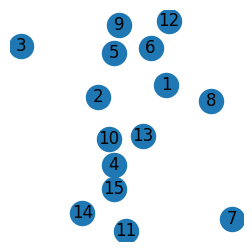

[('1', (1150, 1760)), ('2', (630, 1660)), ('3', (40, 2090)), ('4', (750, 1100)), ('5', (750, 2030)), ('6', (1030, 2070)), ('7', (1650, 650)), ('8', (1490, 1630)), ('9', (790, 2260)), ('10', (710, 1310)), ('11', (840, 550)), ('12', (1170, 2300)), ('13', (970, 1340)), ('14', (510, 700)), ('15', (750, 900))]


In [8]:
#creating an instance from "bays29.tsp"
cities = [(i,(0,0)) for i in range(15)]
n_mat = nodes_matrix.copy()
for i in range(15):
    cities[i] = (str(n_mat[i][0]), (n_mat[i][1], n_mat[i][2]))
plot_city(cities)
print(cities)

#### Prepare binary vector with bit (𝑖,𝑗) representing to visit 𝑗 city at time 𝑖

In [9]:
n_city = len(cities)
x = Array.create('c', (n_city, n_city), 'BINARY')

In [10]:
# Constraint not to visit more than two cities at the same time.
# equation (6) implemented here
# time_const + city_const = H_a
time_const = 0.0
for i in range(n_city):
    # If you wrap the hamiltonian by Const(...), this part is recognized as constraint
    time_const += Constraint((sum(x[i, j] for j in range(n_city)) - 1)**2, label="time{}".format(i))

# Constraint not to visit the same city more than twice.
city_const = 0.0
for j in range(n_city):
    city_const += Constraint((sum(x[i, j] for i in range(n_city)) - 1)**2, label="city{}".format(j))

In [11]:
# distance of route
# equation (5) implemented here
distance = 0.0
for i in range(n_city):
    for j in range(n_city):
        for k in range(n_city):
            d_ij = dist(i, j, cities)
            distance += d_ij * x[k, i] * x[(k+1)%n_city, j]  # sum(d_uv) in eq.5 i.e. H_b

<img src= "Screenshot (59).png">

In [12]:
# Construct hamiltonian
A = Placeholder("A")  # the relaxation parameter
H = distance + A * (time_const + city_const)  # Eq (4)

In [13]:
# Compile model
model = H.compile()

In [14]:
# Generate QUBO
# maybe we can add a loop to go through different relaxation parameter here
feed_dict = {'A': 1500.0}  # setting it to upper bound of the coordinate works!!!
bqm = model.to_bqm(feed_dict=feed_dict)

In [15]:
import neal
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=128, num_sweeps=100)

# Decode solution
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key=lambda x: x.energy)
energy = best_sample.energy
num_broken = len(best_sample.constraints(only_broken=True))
print("number of broken constraint = {}".format(num_broken))

number of broken constraint = 0


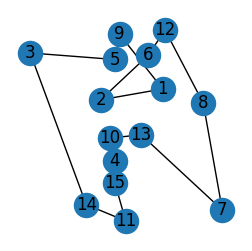

8504.608304247027


In [16]:
if num_broken == 0:
    plot_city(cities, best_sample)
    print(energy)

In [22]:
infeasible_ctr = 0
for i in range(128):
    if len(decoded_samples[i].constraints(only_broken=True)) > 0:
        infeasible_ctr += 1
P_f = (128-infeasible_ctr)/128
print(f"P_f for {feed_dict} is {P_f}")

P_f for {'A': 1990} is 1.0


In [27]:
sa = neal.SimulatedAnnealingSampler()
Pf_arr = []
r_arr = []
for r in range (800, 2000, 20):
    feed_dict = {'A': r}   
    bqm = model.to_bqm(feed_dict=feed_dict)
    sampleset = sa.sample(bqm, num_reads=128, num_sweeps=128)

    decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
    best_sample = min(decoded_samples, key=lambda x: x.energy)
    energy = best_sample.energy
    num_broken = len(best_sample.constraints(only_broken=True))
    infeasible_ctr = 0
    for i in range(128):
        if len(decoded_samples[i].constraints(only_broken=True)) > 0:
            infeasible_ctr += 1
    P_f = (128-infeasible_ctr)/128
    print(f"P_f for {feed_dict} is {P_f}")
    Pf_arr.append(P_f)
    r_arr.append(r)

P_f for {'A': 800} is 0.0
P_f for {'A': 820} is 0.0
P_f for {'A': 840} is 0.0
P_f for {'A': 860} is 0.0
P_f for {'A': 880} is 0.0078125
P_f for {'A': 900} is 0.0078125
P_f for {'A': 920} is 0.03125
P_f for {'A': 940} is 0.0078125
P_f for {'A': 960} is 0.046875
P_f for {'A': 980} is 0.09375
P_f for {'A': 1000} is 0.0859375
P_f for {'A': 1020} is 0.109375
P_f for {'A': 1040} is 0.140625
P_f for {'A': 1060} is 0.2109375
P_f for {'A': 1080} is 0.234375
P_f for {'A': 1100} is 0.296875
P_f for {'A': 1120} is 0.265625
P_f for {'A': 1140} is 0.2734375
P_f for {'A': 1160} is 0.3984375
P_f for {'A': 1180} is 0.46875
P_f for {'A': 1200} is 0.3828125
P_f for {'A': 1220} is 0.4375
P_f for {'A': 1240} is 0.46875
P_f for {'A': 1260} is 0.59375
P_f for {'A': 1280} is 0.640625
P_f for {'A': 1300} is 0.6640625
P_f for {'A': 1320} is 0.6484375
P_f for {'A': 1340} is 0.671875
P_f for {'A': 1360} is 0.7578125
P_f for {'A': 1380} is 0.78125
P_f for {'A': 1400} is 0.765625
P_f for {'A': 1420} is 0.78125
P_f 

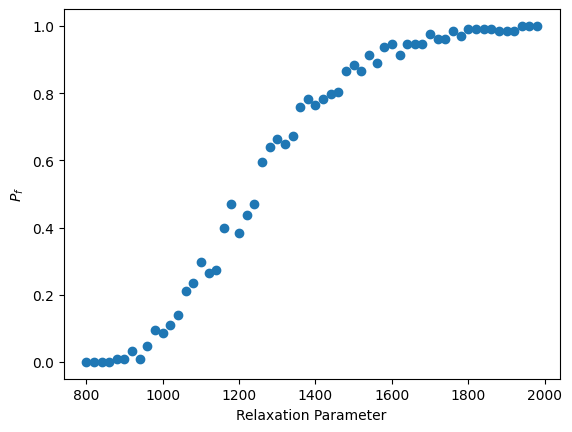

In [30]:
plt.scatter(r_arr,Pf_arr)
plt.xlabel("Relaxation Parameter")
plt.ylabel("$P_f$")
plt.show()